In [73]:
import csv
import numpy as np
import pandas as pd
import numpy as np
import os
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import Polynomial
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [74]:
df = pd.read_csv('truncated_combined_averaged.csv')

In [75]:
pp_dict = {'Basalt 0deg': 1.008, 'Hemp 45deg': 1.032, 'Flax 45deg': 0.966, 'Basalt Hemp 0deg': 1.025, 'Hemp 0deg': 1.044, 'Flax 0deg': 0.935, 'Basalt Flax 0deg': 1.065, 'Basalt 45deg': 0.922}

In [76]:

for material_id, group in df.groupby('Material_ID'):
    # divide all 'force' values by the corresponding pp_dict value
    df.loc[df['Material_ID'] == material_id, 'Force'] = df.loc[df['Material_ID'] == material_id, 'Force'] / pp_dict[material_id] * 1000 * (1 / 0.0001)
    # divide all 'displacement' values by 75
    df.loc[df['Material_ID'] == material_id, 'Displacement'] = df.loc[df['Material_ID'] == material_id, 'Displacement'] / 75

# change name of displacement column to strain
df.rename(columns={'Displacement': 'Strain'}, inplace=True)
# change name of force column to stress
df.rename(columns={'Force': 'Stress'}, inplace=True)
# save the new dataframe to a new csv file
df.to_csv('stress_strain.csv', index=False)

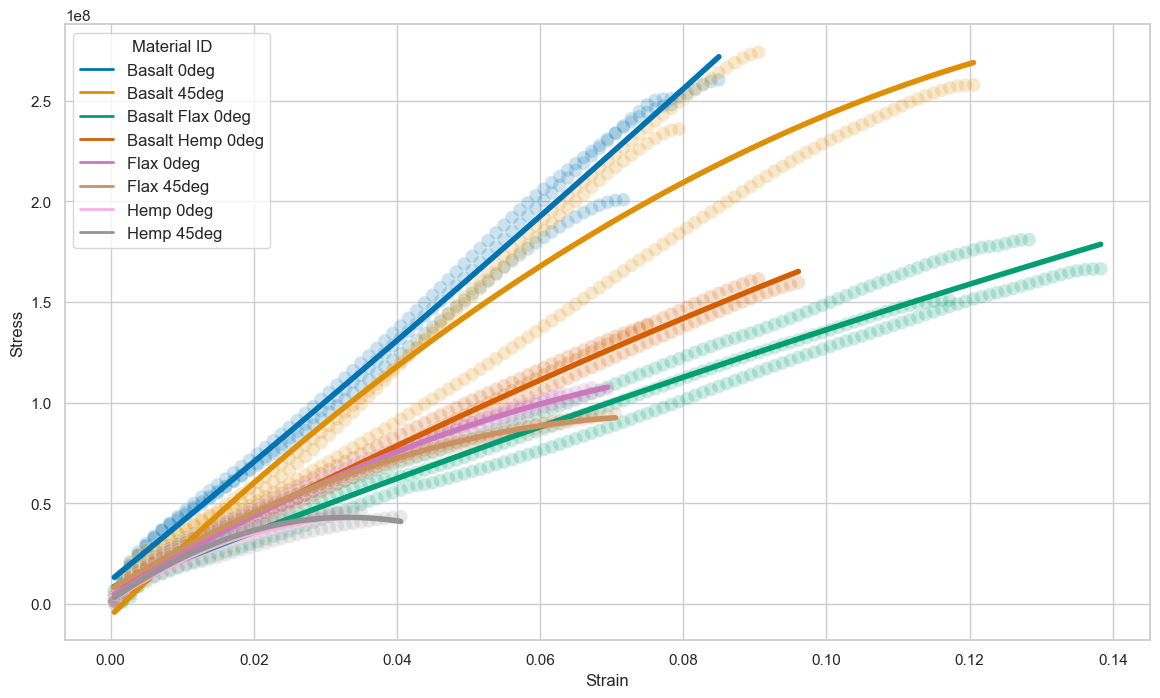

C:\Users\james\AppData\Local\Temp\ipykernel_16744\820191485.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Material_ID', y='Stress', data=max_values, palette=palette)


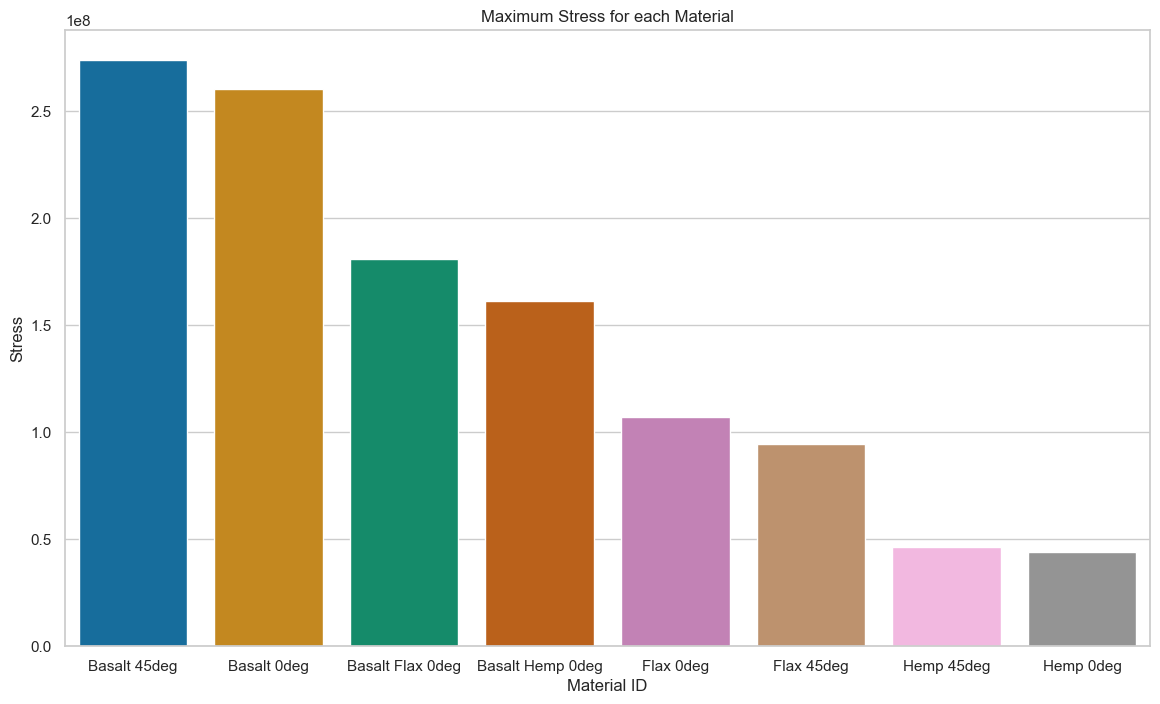

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from matplotlib.lines import Line2D  # Import Line2D for custom legend handles

sns.set(style="whitegrid")

# Load the data
df = pd.read_csv('stress_strain.csv')

# Change figure size
plt.figure(figsize=(14, 8))

# Create a color palette with a distinct color for each Material_ID
palette = sns.color_palette("colorblind", len(df['Material_ID'].unique()))

# Plot the scatter plot using the palette
scatter = sns.scatterplot(x='Strain', y='Stress', hue='Material_ID', data=df, alpha=0.2, s=100, palette=palette)

# Initialize an empty list for custom legend handles
custom_legend_handles = []

# Plot polynomial fit for each material with matching color
for material_id, group in df.groupby('Material_ID'):
    x = group['Strain'].values.reshape(-1, 1)
    y = group['Stress'].values

    # Create a RANSAC regressor with a polynomial model
    ransac = make_pipeline(PolynomialFeatures(degree=2), RANSACRegressor(random_state=42))
    ransac.fit(x, y)
    # Generate x values from the min to max strain for the material
    x = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    # Calculate the y values using the RANSAC polynomial model
    y_ransac = ransac.predict(x)

    # Plot and retrieve the color used for the line
    line = plt.plot(x, y_ransac, linewidth=4, color=palette[df['Material_ID'].unique().tolist().index(material_id)])
    
    # Add a custom legend handle for this line
    custom_legend_handles.append(Line2D([0], [0], color=line[0].get_color(), linewidth=2))

# Clear the existing scatter plot legend
scatter.legend_.remove()

# Create a custom legend using the handles and labels from the regression lines
plt.legend(custom_legend_handles, df['Material_ID'].unique(), title="Material ID", fontsize='medium')

plt.show()

#make bar plot with max values
max_values = df.groupby('Material_ID').max()
max_values.reset_index(inplace=True)
max_values = max_values.sort_values('Stress', ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x='Material_ID', y='Stress', data=max_values, palette=palette)
plt.title('Maximum Stress for each Material')
plt.xlabel('Material ID')
plt.ylabel('Stress')
plt.show()



#### Young's Modulus

        Material_ID  Youngs_Modulus
0       Basalt 0deg    2.906499e+09
1      Basalt 45deg    3.505377e+09
2  Basalt Flax 0deg    1.409185e+09
3  Basalt Hemp 0deg    1.877976e+09
4         Flax 0deg    2.209001e+09
5        Flax 45deg    2.187038e+09
6         Hemp 0deg    2.369715e+09
7        Hemp 45deg    2.488738e+09


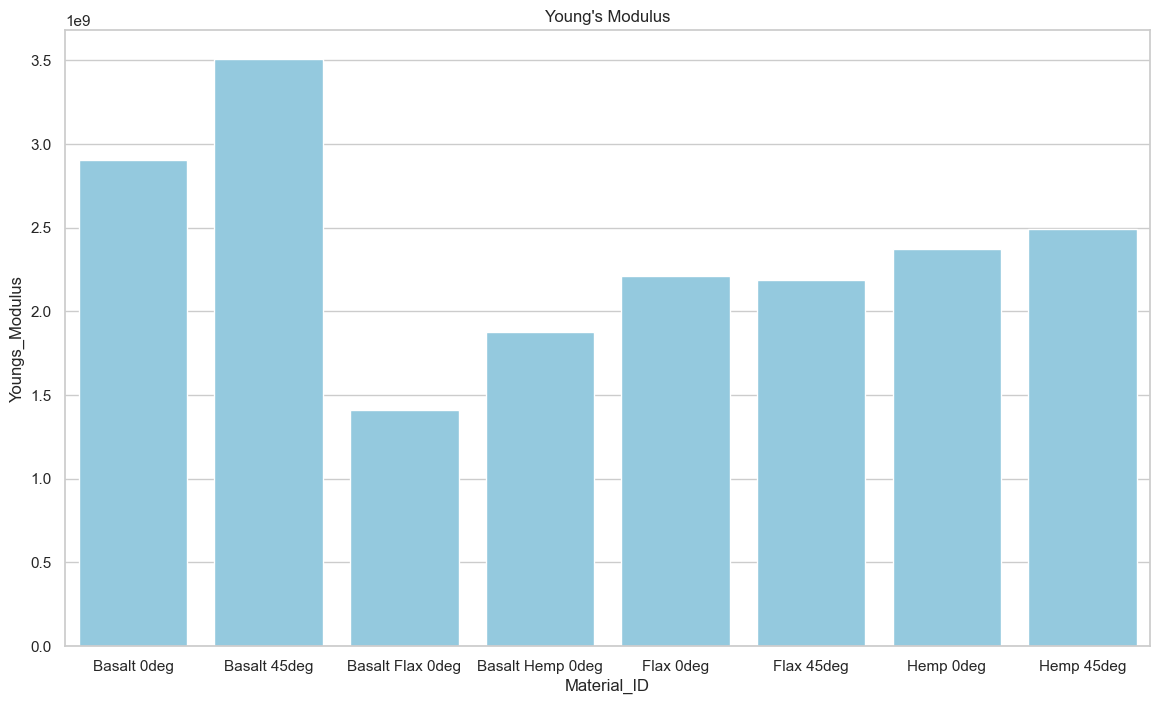

In [78]:
# calculate young's modulus
youngs_modulus = []
for material_id, group in df.groupby('Material_ID'):
    x = group['Strain'].values.reshape(-1, 1)
    y = group['Stress'].values
    ransac = make_pipeline(PolynomialFeatures(degree=2), RANSACRegressor(random_state=42))
    ransac.fit(x, y)
    youngs_modulus.append(ransac.named_steps['ransacregressor'].estimator_.coef_[1])

# create a dataframe with the young's modulus values
youngs_modulus_df = pd.DataFrame({'Material_ID': df['Material_ID'].unique(), 'Youngs_Modulus': youngs_modulus})
print(youngs_modulus_df)

# plot the young's modulus values
plt.figure(figsize=(14, 8))
youngs_modulus_plot = sns.barplot(x='Material_ID', y='Youngs_Modulus', data=youngs_modulus_df, color='skyblue')
plt.title("Young's Modulus")
plt.show()



While the traditional approach to calculating Young's Modulus involves using linear regression on the initial linear portion of the stress-strain curve, your original approach using a RANSACRegressor with polynomial features could be considered advantageous under certain conditions. Here are some arguments that could be made in favor of the original approach:

1. Robustness to Outliers:
Argument: The RANSAC (Random Sample Consensus) algorithm is robust to outliers, which are common in experimental data due to measurement errors or anomalies in material behavior. By using RANSAC, your calculation of Young's Modulus might be less affected by these outliers, potentially providing a more accurate estimate under real-world conditions where data isn't perfectly clean.
Contextual Relevance: Especially relevant for experimental data with significant noise or when the exact linear portion of the curve is difficult to isolate due to anomalies.
2. Accommodation of Non-linear Pre-yield Behavior:
Argument: Some materials exhibit non-linear elastic behavior before yielding, which cannot be accurately captured by a simple linear model. The use of polynomial features allows for a more nuanced model that can better fit these non-linear characteristics in the pre-yield region, potentially leading to a more accurate representation of the material's behavior.
Contextual Relevance: Particularly applicable for materials with noticeable non-linear elasticity or when the stress-strain curve does not strictly follow Hooke's law even in the elastic region.
3. Adaptability and Flexibility:
Argument: The polynomial model provides flexibility in fitting various shapes of stress-strain curves, making it adaptable to a wide range of materials with different behaviors. This adaptability could be useful in exploratory phases of research when the material properties or the most appropriate model are not well-defined.
Contextual Relevance: Useful in research and development settings where materials are being tested for novel applications, and their stress-strain behavior is not fully understood.
4. Useful for Preliminary Analysis:
Argument: For a preliminary analysis where quick estimations are needed across a wide range of materials without detailed scrutiny of each stress-strain curve, the polynomial RANSAC approach allows for fast, automated processing of data. This can be particularly advantageous in high-throughput testing environments.
Contextual Relevance: Applicable in scenarios where the goal is to screen materials for further testing rather than to obtain precise measurements of mechanical properties.
Considerations and Caveats:
While there are arguments in favor of using a RANSACRegressor with polynomial features for calculating Young's Modulus, it's important to be mindful of its limitations and the specific context in which it is applied. The accuracy and appropriateness of this method depend heavily on the characteristics of the material being studied and the quality of the data. It is also crucial to communicate the assumptions and potential limitations of this approach when presenting results.

In any case, whether this method is "better" largely depends on the specific goals of the analysis, the nature of the materials under investigation, and the available data. It could be beneficial to compare results from both methods to evaluate their consistency and determine the most appropriate approach for your specific needs.

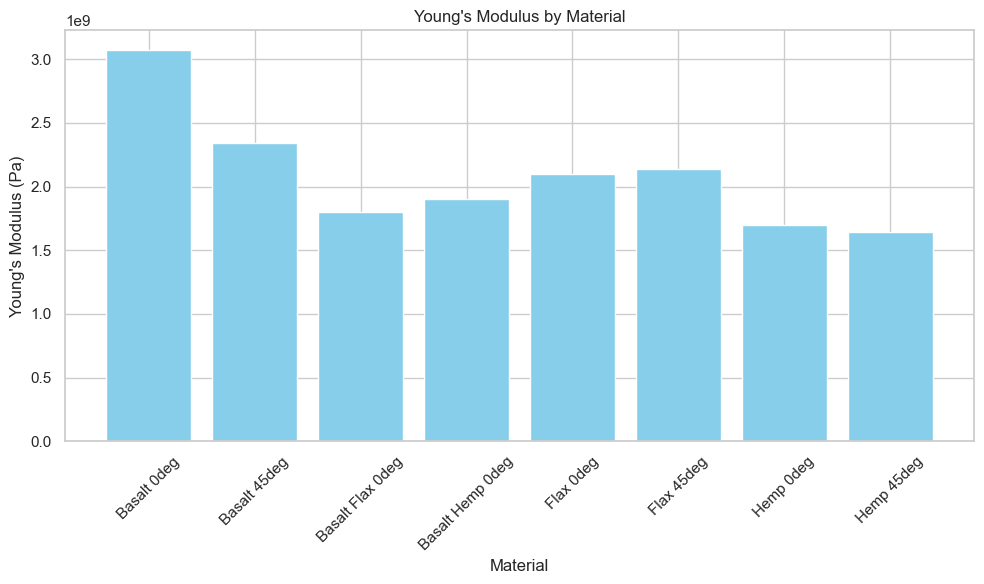

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming df is already loaded
# df = pd.read_csv('stress_strain.csv')

# Placeholder for Young's Modulus values
young_moduli = {}

# Analyze the initial linear portion of the stress-strain curve for each material
# Adjust these limits according to your data
linear_strain_min = 0.0
linear_strain_max = 0.02  # Example strain range for linear portion

for material_id, group in df.groupby('Material_ID'):
    # Filter data for linear region
    linear_region = group[(group['Strain'] >= linear_strain_min) & (group['Strain'] <= linear_strain_max)]
    
    # Perform linear regression
    model = LinearRegression().fit(linear_region[['Strain']], linear_region['Stress'])
    
    # Slope of the regression line is Young's Modulus
    young_moduli[material_id] = model.coef_[0]

# Plotting Young's Modulus for each material
materials = list(young_moduli.keys())
moduli = list(young_moduli.values())

plt.figure(figsize=(10, 6))
plt.bar(materials, moduli, color='skyblue')
plt.xlabel('Material')
plt.ylabel('Young\'s Modulus (Pa)')
plt.title('Young\'s Modulus by Material')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
